In [6]:
# For importing utils
import sys
sys.path.append("..")

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
from utils import PERTURBATIONS

In [8]:
def get_marker_surprisals(perturbation, seed, ckpt, model):

    # Load surprisal DataFrame
    surprisals_path = "agreement_surprisal_results/{}_100M/{}_seed{}.csv"
    surprisal_df = pd.read_csv(surprisals_path.format(perturbation, model, seed))
    
    # Get summary stats for suprisal differences
    marker_token_surprisals = surprisal_df[f"Grammatical Token Surprisals (ckpt {ckpt})"]

    return marker_token_surprisals.mean()

def get_summary_stats(l):
    # Calculate confidence interval using t-distribution
    mean = np.mean(l)
    sem = stats.sem(l)
    ci_lower, ci_upper = stats.t.interval(0.95, df=len(l)-1, loc=mean, scale=sem)
    return mean, (ci_upper - ci_lower) / 2
    

In [9]:
def plot_surprisals(ax, seeds, ckpt, colors, hatches, surprisal_fn, model_type):

    control_agreement_seeds = []
    local_agreement_seeds = []
    for seed in seeds:
        # Get summary stats for each hop model
        avg_control_agreement = surprisal_fn("control_agreement", seed, ckpt, "control_agreement_"+model_type)
        avg_local_agreement = surprisal_fn("local_agreement", seed, ckpt, "local_agreement_"+model_type)

        # Append results
        control_agreement_seeds.append(avg_control_agreement)
        local_agreement_seeds.append(avg_local_agreement)

    if len(seeds) > 1:
        # Prepare data to plot
        summary_stats = [
            get_summary_stats(control_agreement_seeds),
            get_summary_stats(local_agreement_seeds),
        ]
    else:
        summary_stats = [
            (control_agreement_seeds[0], 0),
            (local_agreement_seeds[0], 0),
        ]

    x = np.arange(3)  # label locations
    width = 0.8  # width of the bars

    # Iterate over pos / no pos groups
    for i, (avg, err) in enumerate(summary_stats):
        # Iterate over models and plot bars
        color = colors[i]
        hatch = hatches[i]
        ax.bar(x[i], avg, width, yerr=err, label=None,
                color=color, hatch=hatch, edgecolor="w", zorder=2)

    ax.set_xticks([])
    ax.grid(zorder=0, color="lightgray")
    ax.set_title(f"{ckpt} Steps")


def plot_surprisal_differences_checkpoints(seeds, checkpoints, title, model_type):

    # Colors patterns for bars
    color1=PERTURBATIONS["control_agreement"]["color"]
    color2=PERTURBATIONS["local_agreement"]["color"]
    colors = [color1, color2]

    hatch1 = ''
    hatch2 = '///'
    hatch3 = '..'
    hatches = [hatch1, hatch2, hatch3]

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharey=True)
    axes_flat = axs.flatten()

    surprisal_fn = get_marker_surprisals

    # Call individual plot function with different parameters for each subplot
    for i, checkpoint in enumerate(checkpoints):
        plot_surprisals(
            axes_flat[i], seeds, checkpoint, colors, hatches, surprisal_fn, model_type)

    legend_elements = [Patch(facecolor=color1, hatch=hatch1,
                             edgecolor="w", label='ControlAgreement'),
                       Patch(facecolor=color2, hatch=hatch2,
                             edgecolor="w", label='LocalAgreement'),]
    fig.legend(handles=legend_elements, ncol=2, loc="center",
                bbox_to_anchor=(0.55, 0), frameon=False)
        
    fig.supylabel(title, fontsize=12, x=0.04)

    # Adjust layout and show plot
    plt.tight_layout()


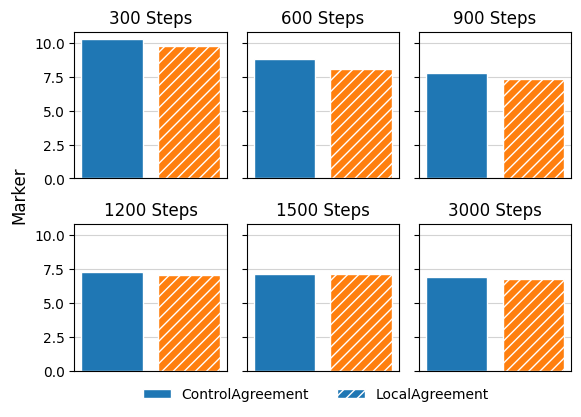

In [10]:
CHECKPOINTS = [300, 600, 900, 1200, 1500, 3000]
plot_surprisal_differences_checkpoints(seeds=[53], checkpoints=CHECKPOINTS, title="Marker", model_type="gpt2")

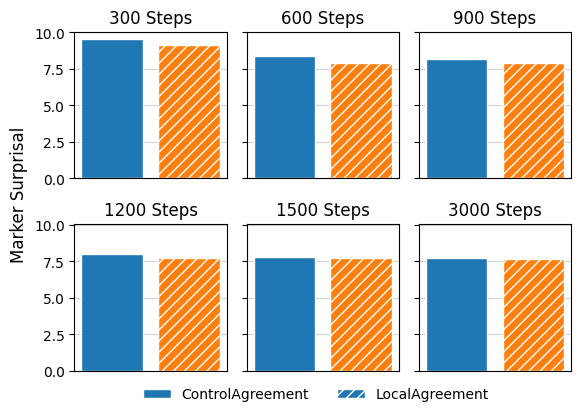

In [11]:
plot_surprisal_differences_checkpoints(seeds=[53], checkpoints=CHECKPOINTS, title="Marker Surprisal", model_type="alibi")

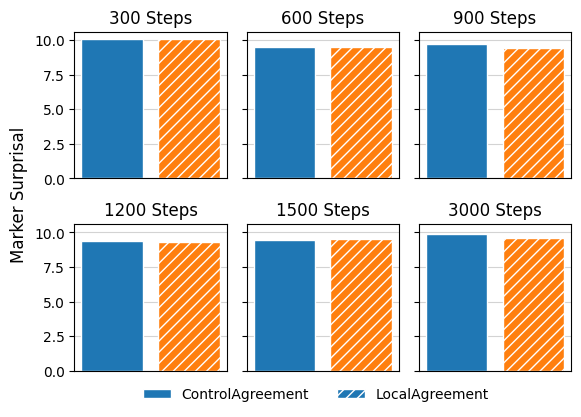

In [12]:
plot_surprisal_differences_checkpoints(seeds=[53], checkpoints=CHECKPOINTS, title="Marker Surprisal", model_type="geom_attn")